# KNN

## Описание модели

[Метод k-ближайших соседей](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) (англ. k-nearest neighbors algorithm, k-NN) — метрический алгоритм для классификации или регрессии. В случае классификации алгоритм сводится к следующему:

1. Рассматриваются объекты из обучающей выборки, для которых известно, к какому классу они принадлежат.
1. Между подлежащими классификации объектами и объектами тренировочной выборки вычисляется матрица попарных расстояний согласно выбранной метрике.
1. На основе полученной матрицы расстояний для каждого из подлежащих классификации объектов определяется k ближайших объектов тренировочной выборки — k ближайших соседей.
1. Подлежащим классификации объектам приписывается тот класс, который чаще всего встречается у их k ближайших соседей.


<img src ="https://edunet.kea.su/repo/EduNet-content/L01/out/knn_idea.png" width="600">

В качестве примера работы с алгоритмом k-NN классифицируем изображение корабля из тестовой выборки CIFAR-10 с использованием [реализации алгоритма в scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html).

#### Описание данных

Предположим, что мы работаем с тренировочным датасетом CIFAR-10 и хотим решить хрестоматийную задачу классификации: определить те картинки из тестового набора данных, которые относятся к классу cat. Эта задача является частным примером общей задачи классификации данных CIFAR-10, разные подходы к решению которой мы ещё неоднократно рассмотрим в ходе первых лекций.

Датасет CIFAR-10 содержит, как следует из названия, 10 различных классов изображений:

<img src ="https://edunet.kea.su/repo/EduNet-content/L01/out/knn_on_cifar10.png" width="700" >

Все изображения представляют собой матрицы чисел, которые кодируют цвета отдельных пикселей. Для изображений высоты $H$, ширины $W$ с $C$ цветовыми каналами получаем упорядоченный набор  $H \times W \times C$ чисел. В данном разделе пока не будем учитывать, что значения соседних пикселей изображения могут быть значительно связаны, и будем решать задачу классификации для наивного представления изображения в виде точки в  $H \times W \times C$-мерном вещественном пространстве.

<img src ="https://edunet.kea.su/repo/EduNet-content/L01/out/img_to_array.png" width="700" >

Датасет CIFAR-10 содержит цветные (трехцветные) изображения размером $32 \times 32$ пикселя. Таким образом, каждое изображение из датасета является точкой в $3072$-мерном ($32 \times 32 \times 3 = 3072$) вещественном пространстве.

#### Близость данных согласно метрике

Пара изображений будет выглядеть практически идентично, если значения цветов соответствующих пикселей будут похожи по величине. Другими словами, практически идентичным изображениям будут соответствовать **близкие** точки нашего многомерного вещественного пространства. Для численной характеристики **близости**, можно определить функцию подсчета расстояния между парой точек — метрику.

Известны различные способы задания [функции расстояния между парой точек](https://en.wikipedia.org/wiki/Metric_(mathematics)). Простейшим примером является широко известная **Евклидова** ($L_2$) метрика:
$$L_2 (X, Y) = \sum_i (X_i - Y_i)^2,$$

Но, кроме неё, величина расстояния между парой точек может быть выражена рядом других функций.

$L_1$-расстояние (манхэттенская метрика):
$$L_1 (X, Y) = \sum_i |X_i - Y_i|,$$

угловое расстояние:
$$ang (X, Y) = \frac{1}{\pi} \arccos \frac{\sum_i X_i Y_i}{\sqrt{\sum_i X_i^2} \sqrt{\sum_i Y_i^2}} ,$$

и многие другие. От выбора конкретной функции расстояния между точками будет явно зависеть представление о **близости** точек — объекты, близкие по одной из метрик, вовсе не обязаны оказаться близкими согласно другой.

Давайте попробуем вычислить $L_1$-расстояние между несколькими первыми изображениями из тестового набора данных CIFAR-10 с использованием реализованного в пакете [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.DistanceMetric.html) класса `sklearn.metrics.DistanceMetric`

$$\large L1\;distance:\; d_1(I_1, I_2) = \sum_p|I^p_1 - I^p_2|$$

<center><img src ="https://edunet.kea.su/repo/EduNet-content/L01/out/metric_to_compare_train_and_test_imgs.png" width="800"></center>

Загрузим данные:

In [1]:
from IPython.display import clear_output
from torchvision import datasets

# Load dataset from torchvision.datasets
train_set = datasets.CIFAR10("content", train=True, download=True)
val_set = datasets.CIFAR10("content", train=False, download=True)
labels_names = train_set.classes
clear_output()

ModuleNotFoundError: No module named 'torchvision'

Выберем три изображения из тестового набора данных:

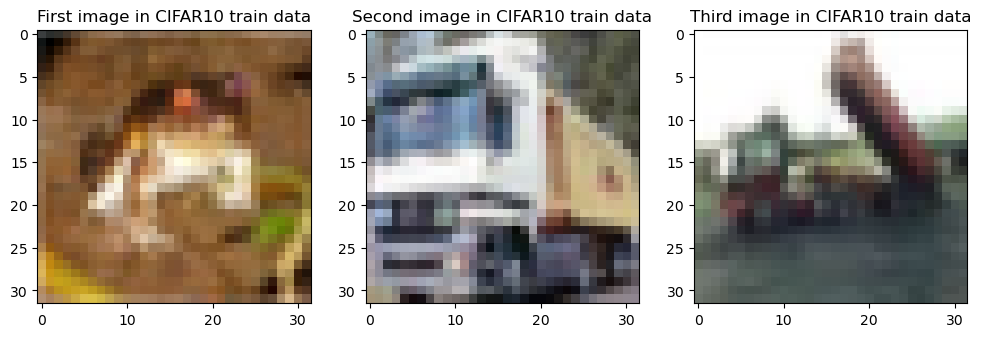

In [2]:
import matplotlib.pyplot as plt

img_1 = train_set.data[0]
img_2 = train_set.data[1]
img_3 = train_set.data[2]

fix, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].set_title("First image in CIFAR10 train data")
ax[0].imshow(img_1)
ax[1].set_title("Second image in CIFAR10 train data")
ax[1].imshow(img_2)
ax[2].set_title("Third image in CIFAR10 train data")
ax[2].imshow(img_3)
plt.show()

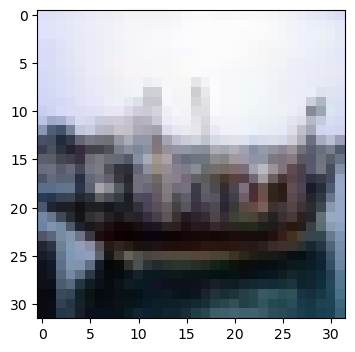

In [3]:
sample_ship_img = val_set.data[18]
plt.figure(figsize=(4, 4))
plt.imshow(sample_ship_img)
plt.show()

In [4]:
from sklearn.neighbors import KNeighborsClassifier

# in order to limit computational time
index_limiter = 5000
x = train_set.data.reshape(train_set.data.shape[0], -1)[:index_limiter]
y = train_set.targets[:index_limiter]

for metric_type in ["euclidean", "manhattan", "chebyshev"]:
    print()
    for k in range(3, 7, 1):
        knn = KNeighborsClassifier(n_neighbors=k, metric=metric_type)
        knn.fit(x, y)
        result_class_id = knn.predict([sample_ship_img.flatten()])[0]
        result_class = train_set.classes[result_class_id]
        print(f"{k}-NN with {metric_type} metric\npredicted class is: {result_class}\n")


3-NN with euclidean metric
predicted class is: automobile

4-NN with euclidean metric
predicted class is: ship

5-NN with euclidean metric
predicted class is: ship

6-NN with euclidean metric
predicted class is: ship


3-NN with manhattan metric
predicted class is: automobile

4-NN with manhattan metric
predicted class is: automobile

5-NN with manhattan metric
predicted class is: truck

6-NN with manhattan metric
predicted class is: ship


3-NN with chebyshev metric
predicted class is: ship

4-NN with chebyshev metric
predicted class is: ship

5-NN with chebyshev metric
predicted class is: ship

6-NN with chebyshev metric
predicted class is: ship



## Нормализация данных

Загрузим датасет с образцами здоровой и раковой ткани. Датасет состоит из 569 примеров, где каждой строчке из 30 признаков соответствует класс `1` злокачественной (*malignant*) или `0` доброкачественной (*benign*) ткани. Задача состоит в том, чтобы по 30 признакам обучить модель определять тип ткани (злокачественная или доброкачественная).

Можно иметь сколь угодно хороший алгоритм для классификации, но до тех пор, пока данные на входе — мусор, на выходе из нашего чудесного классификатора мы тоже будем получать мусор **(*garbage in - garbage out*)**. Давайте разберемся, что конкретно надо сделать, чтобы k-NN реально заработал.


In [5]:
import sklearn.datasets

cancer = sklearn.datasets.load_breast_cancer()  # load data

x = cancer.data  # features
y = cancer.target  # labels(classes)
print(f"x shape: {x.shape}, y shape: {y.shape}")
print(f"x[0]: \n {x[0]}")
print(f"y[0]: \n {y[0]}")

x shape: (569, 30), y shape: (569,)
x[0]: 
 [1.799e+01 1.038e+01 1.228e+02 1.001e+03 1.184e-01 2.776e-01 3.001e-01
 1.471e-01 2.419e-01 7.871e-02 1.095e+00 9.053e-01 8.589e+00 1.534e+02
 6.399e-03 4.904e-02 5.373e-02 1.587e-02 3.003e-02 6.193e-03 2.538e+01
 1.733e+01 1.846e+02 2.019e+03 1.622e-01 6.656e-01 7.119e-01 2.654e-01
 4.601e-01 1.189e-01]
y[0]: 
 0


Посмотрим, сколько данных в классе `0` и сколько данных в классе `1`

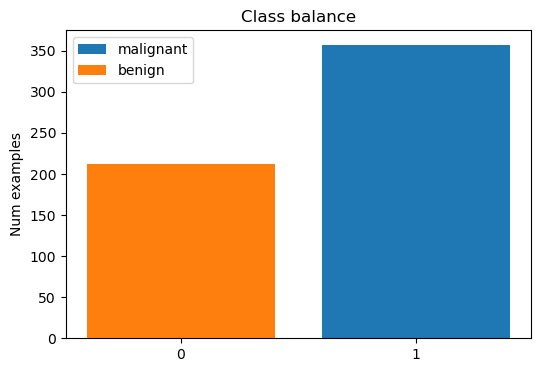

In [6]:
plt.figure(figsize=(6, 4))  # set figure size
plt.bar(1, y[y == 1].shape, label=cancer.target_names[0])  # 1 label
plt.bar(0, y[y == 0].shape, label=cancer.target_names[1])  # 0 label
plt.title("Class balance")
plt.ylabel("Num examples")
plt.xticks(ticks=[1, 0], labels=["1", "0"])
plt.legend(loc="upper left")
plt.show()

Теперь давайте посмотрим на сами данные. У нас есть 569 строк, в каждой из которых по 30 колонок. Такие колонки называют признаками или *features*. Попробуем математически описать все эти признаки (mean, std, min и тд)

In [7]:
import pandas as pd

pd.DataFrame(x).describe()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


То же самое, но в виде графика. Видно, что у признаков совершенно разные значения.

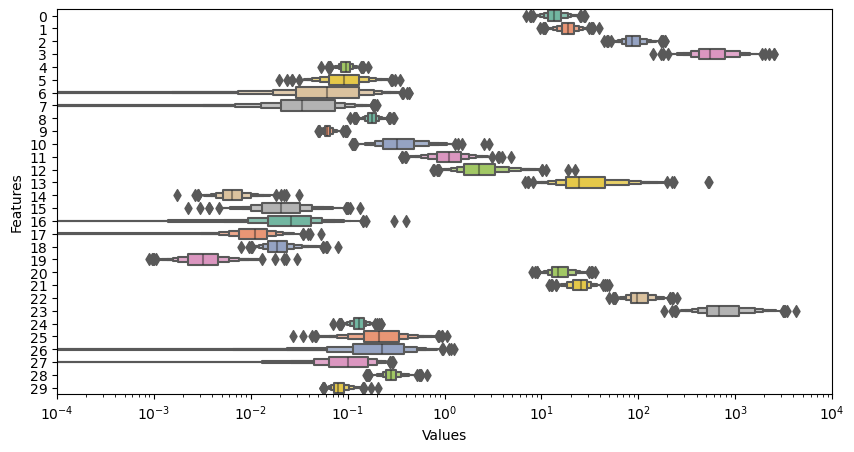

In [8]:
import seaborn as sns

plt.figure(figsize=(10, 5))
ax = sns.boxenplot(data=pd.DataFrame(x), orient="h", palette="Set2")
ax.set(xscale="log", xlim=(1e-4, 1e4), xlabel="Values", ylabel="Features")
plt.show()

Чтобы адекватно сравнить данные между собой, нам следует использовать нормализацию.

**Нормализация, выбор Scaler**

Нормализацией называется процедура приведения входных данных к единому масштабу (диапазону) значений. Фактически, это означает построение взаимно однозначного соответствия между некоторыми размерными величинами (которые измеряются в метрах, килограммах, годах и т. п.) и их безразмерными аналогами, принимающими значение в строго определенном числовом диапазоне (скажем, на отрезке $[0,1]$). Преобразование данных к единому числовому диапазону (иногда говорят *домену*) позволяет считать их равноправными признаками и единообразно передавать их на вход модели. В некоторых источниках данная процедура явно называется *масштабирование*.

$$\text{scaling map} \; : \text{some arbitrary feature domain} \rightarrow \text{definite domain} $$

Иногда под нормализацией данных понимают процедуру *стандартизации*, то есть приведение множеств значений всех признаков к стандартному нормальному распределению — распределению с нулевым средним значением и единичной дисперсией.

$$\text{standartization map} : f_i \rightarrow (f_i - \text{mean} (\{f_i\})) \cdot \frac{1}{\text{std} (\{f_i\})}$$

Рассмотрим небольшой пример. Пусть у нас есть данные о некоторой группе людей, содержащие два признака: *возраст* (в годах) и *размер дохода* (в рублях). Возраст может измениться в диапазоне от 18 до 70 ( интервал 70-18 = 52). А доход от 30 000 р до 500 000 р (интервал 500 000 - 30 000 = 470 000). В таком варианте разница в возрасте имеет меньшее влияние, чем разница в доходе. Получается, что доход становится более важным признаком, изменения в котором влияют больше при сравнении схожести двух людей.

Должно быть так, чтобы максимальные изменения любого признака в «основной массе объектов» были одинаковы. Тогда потенциально все признаки будут равноценны.

Осталось определиться с выбором инструмента. Часто используют следующие варианты: `MinMaxScaler`, `StandardScaler`, `RobustScaler`.

Сравним `MinMaxScaler`, `StandardScaler`, `RobustScaler` для признака `data[:,0]`. **Обратите внимание на ось X**

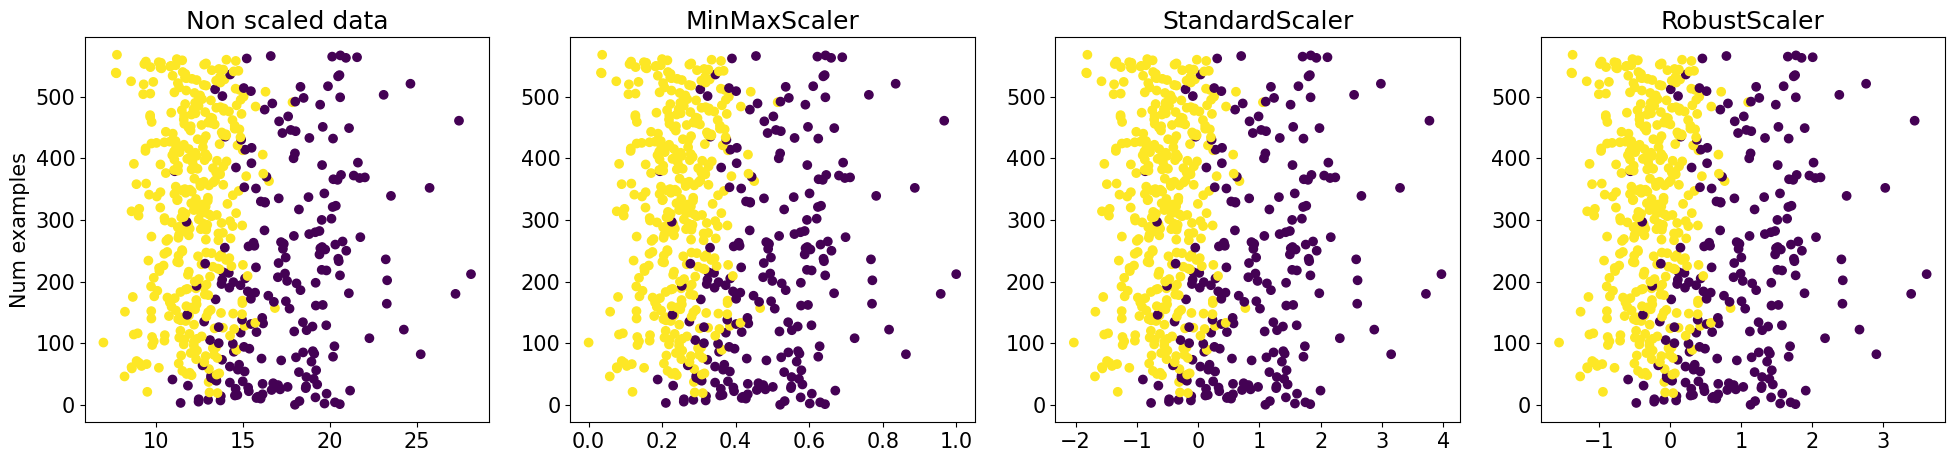

In [9]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler


test = x[:, 0].reshape(-1, 1)

plt.figure(1, figsize=(24, 5))
plt.subplot(141)  # set location
plt.scatter(test, range(len(test)), c=y)
plt.ylabel("Num examples", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title("Non scaled data", fontsize=18)

# scale data with MinMaxScaler
test_scaled = MinMaxScaler().fit_transform(test)
plt.subplot(142)
plt.scatter(test_scaled, range(len(test)), c=y)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title("MinMaxScaler", fontsize=18)

# scale data  with StandardScaler
test_scaled = StandardScaler().fit_transform(test)
plt.subplot(143)
plt.scatter(test_scaled, range(len(test)), c=y)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title("StandardScaler", fontsize=18)

# scale data  with RobustScaler
test_scaled = RobustScaler().fit_transform(test)
plt.subplot(144)
plt.scatter(test_scaled, range(len(test)), c=y)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title("RobustScaler", fontsize=18)
plt.show()

Идея **`MinMaxScaler`** заключается в том, что он преобразует данные из имеющегося диапазона значений в диапазон от 0 до 1. Может быть полезно, если нужно выполнить преобразование, в котором отрицательные значения не допускаются (например, масштабирование RGB пикселей).

$$z_i=\frac{X_i-X_{min}}{X_{max}-X_{min}}$$

$z_i$ — масштабированное значение,
$X_i$ — текущее значение,
$X_{min}$ и $X_{max}$ — минимальное и максимальное значения имеющихся данных.

Идея **`StandardScaler`** заключается в том, что он преобразует данные таким образом, что распределение будет иметь среднее значение 0 и стандартное отклонение 1. Большинство значений будет в  диапазоне от -1 до 1. Это стандартная трансформация, и она применима во многих ситуациях.

$$z_i=\frac{X_i-u}{s}$$

$u$ — среднее значение (или 0 при `with_mean=False`) и $s$ — стандартное отклонение (или 0 при `with_std=False`)

И `StandardScaler`, и `MinMaxScaler` очень чувствительны к наличию выбросов. **`RobustScaler`** использует медиану и основан на *процентилях*. k-й процентиль – это величина, равная или не превосходящая k процентов чисел во всем имеющемся распределении. Например, 50-й процентиль (медиана) распределения таково, что 50% чисел из распределения не меньше данного числа. Соответственно, RobustScaler не зависит от небольшого числа очень больших предельных выбросов (outliers). Следовательно, результирующий диапазон преобразованных значений признаков больше, чем для предыдущих скэйлеров и, что более важно, примерно одинаков.

$$z_i=\frac{X_i-X_{median}}{IQR}$$

$X_{median}$ — значение медианы, $IQR$ — межквартильный диапазон равный разнице между 75-ым и 25-ым процентилями

In [10]:
x_norm = StandardScaler().fit_transform(x)  # scaled data

In [11]:
pd.DataFrame(x_norm).describe()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
count,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,...,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02
mean,-3.153111e-15,-6.568462e-15,-6.993039e-16,-8.553985e-16,6.081447e-15,-1.136369e-15,-2.997017e-16,1.023981e-15,-1.860648e-15,-1.504752e-15,...,-2.297713e-15,1.742016e-15,-1.198807e-15,6.118909e-16,-5.094929e-15,-2.122887e-15,6.118909e-16,-1.998011e-16,-2.422589e-15,2.497514e-15
std,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,...,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00
min,-2.029648e+00,-2.229249e+00,-1.984504e+00,-1.454443e+00,-3.112085e+00,-1.610136e+00,-1.114873e+00,-1.261820e+00,-2.744117e+00,-1.819865e+00,...,-1.726901e+00,-2.223994e+00,-1.693361e+00,-1.222423e+00,-2.682695e+00,-1.443878e+00,-1.305831e+00,-1.745063e+00,-2.160960e+00,-1.601839e+00
25%,-6.893853e-01,-7.259631e-01,-6.919555e-01,-6.671955e-01,-7.109628e-01,-7.470860e-01,-7.437479e-01,-7.379438e-01,-7.032397e-01,-7.226392e-01,...,-6.749213e-01,-7.486293e-01,-6.895783e-01,-6.421359e-01,-6.912304e-01,-6.810833e-01,-7.565142e-01,-7.563999e-01,-6.418637e-01,-6.919118e-01
50%,-2.150816e-01,-1.046362e-01,-2.359800e-01,-2.951869e-01,-3.489108e-02,-2.219405e-01,-3.422399e-01,-3.977212e-01,-7.162650e-02,-1.782793e-01,...,-2.690395e-01,-4.351564e-02,-2.859802e-01,-3.411812e-01,-4.684277e-02,-2.695009e-01,-2.182321e-01,-2.234689e-01,-1.274095e-01,-2.164441e-01
75%,4.693926e-01,5.841756e-01,4.996769e-01,3.635073e-01,6.361990e-01,4.938569e-01,5.260619e-01,6.469351e-01,5.307792e-01,4.709834e-01,...,5.220158e-01,6.583411e-01,5.402790e-01,3.575891e-01,5.975448e-01,5.396688e-01,5.311411e-01,7.125100e-01,4.501382e-01,4.507624e-01
max,3.971288e+00,4.651889e+00,3.976130e+00,5.250529e+00,4.770911e+00,4.568425e+00,4.243589e+00,3.927930e+00,4.484751e+00,4.910919e+00,...,4.094189e+00,3.885905e+00,4.287337e+00,5.930172e+00,3.955374e+00,5.112877e+00,4.700669e+00,2.685877e+00,6.046041e+00,6.846856e+00


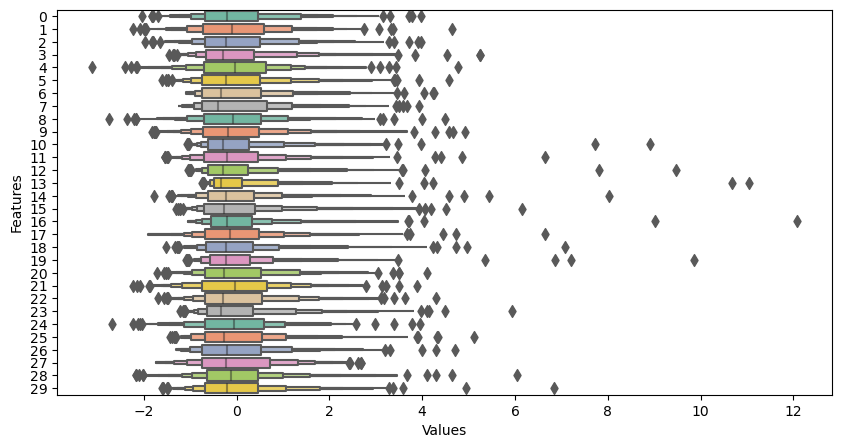

In [12]:
plt.figure(figsize=(10, 5))
ax = sns.boxenplot(data=pd.DataFrame(x_norm), orient="h", palette="Set2")
ax.set(xlabel="Values", ylabel="Features")
plt.show()

Обучим модель на данных без нормировки и с нормировкой для 10-ти соседей.

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier


# split data to train/test
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=25)

knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(x_train, y_train)

print("Without normalization")
accuracy_train = accuracy_score(y_pred=knn.predict(x_train), y_true=y_train)
print("accuracy_train", round(accuracy_train, 3))
accuracy_test = accuracy_score(y_pred=knn.predict(x_test), y_true=y_test)
print("accuracy_test", round(accuracy_test, 3))

Without normalization
accuracy_train 0.946
accuracy_test 0.909


In [14]:
scaler = StandardScaler()
scaler.fit(x_train)
x_train_norm = scaler.transform(x_train)  # scaling data
x_test_norm = scaler.transform(x_test)  # scaling data

knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(x_train_norm, y_train)

print("With normalization")
accuracy_train = accuracy_score(y_pred=knn.predict(x_train_norm), y_true=y_train)
print("accuracy_train", round(accuracy_train, 3))
accuracy_test = accuracy_score(y_pred=knn.predict(x_test_norm), y_true=y_test)
print("accuracy_test", round(accuracy_test, 3))

With normalization
accuracy_train 0.979
accuracy_test 0.951


## Параметры и гиперпараметры модели

Продолжим с классификацией методом ближайших соседей (k-NN).

### k-NN для классификации

На практике метод ближайших соседей для классификации используется крайне редко.
Проблема заключается в следующем: предположим, что точность классификации нас устраивает. Теперь давайте применим k-NN на больших данных (e.g. миллион картинок). Для определения класса каждой из картинок нам нужно сравнить ее со всеми другими картинками в базе данных, а такие расчеты, даже в существенно оптимизированном виде, занимают много времени. Мы же хотим, чтобы обученная модель работала быстро.

Тем не менее, метод ближайших соседей используется в других задачах, где без него обойтись сложно. Например, в задаче распознавания лиц. Представим, что у нас есть большая база данных с фотографиями лиц (например, по 5 разных фотографий всех сотрудников, которые работают в офисном здании, как на примере выше) и есть камера, установленная на входе в это здание. Мы хотим узнать, кто и во сколько пришел на работу. Для того, чтобы понять, кто прошел перед камерой, нам нужно зафиксировать лицо этого человека и сравнить его со всеми фотографиями лиц в базе. В такой формулировке мы не пытаемся определить конкретный класс фотографии, а всего лишь определяем “похож-не похож”. Мы смотрим на k ближайших соседей и, например, если из k соседей, 5 — это фотографии Джеки Чана, то, скорее всего, под камерой прошел именно он. В таких случаях k-NN метод вполне полезен. Похожим образом работает и поиск дубликатов в базах данных.

Примеры эффективной реализации метода на основе k-NN:
* [Facebook AI Research Similarity Search](https://github.com/facebookresearch/faiss) – разработка команды Facebook AI Research для быстрого поиска ближайших соседей и кластеризации в векторном пространстве. Высокая скорость поиска позволяет работать с очень большими данными – до нескольких миллиардов векторов.
* Алгоритм поиска ближайших соседей [Hierarchical Navigable Small World](https://arxiv.org/abs/1603.09320).

### Переобучение k-NN

Теперь обучим k-NN для общей выборки данных, при разном значении количества соседей.

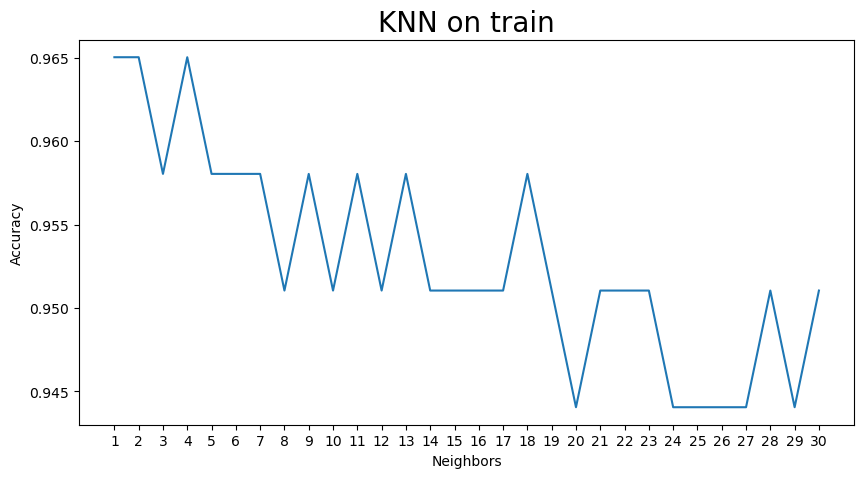

In [15]:
import numpy as np


num_neighbors = np.arange(1, 31)  # array of the numbers of neighbors from 1 to 30

quality = np.zeros(num_neighbors.shape[0])

for i in range(num_neighbors.shape[0]):  # for all elements
    # create knn for all number of neighbors
    knn = KNeighborsClassifier(n_neighbors=num_neighbors[i])
    knn.fit(x_train_norm, y_train)
    q = accuracy_score(y_pred=knn.predict(x_test_norm), y_true=y_test)  # accuracy
    quality[i] = q  # fill quality

plt.figure(figsize=(10, 5))
plt.title("KNN on train", size=20)
plt.xlabel("Neighbors", size=10)
plt.ylabel("Accuracy", size=10)
plt.plot(num_neighbors, quality)
plt.xticks(num_neighbors)
plt.show()

Видим, что качество на 1 соседе самое лучшее. Но это и понятно — ближайшим соседом элемента из обучающей выборки будет сам объект. Мы просто **запомнили** все объекты.

Если теперь мы попробуем взять какой-то новый образец опухоли и классифицировать его, у нас скорее всего ничего не получится. В таких случаях мы говорим, что наша модель не умеет обобщать (*generalization*).

Для того, чтобы знать заранее, обобщает ли наша модель или нет, мы можем разбить все имеющиеся у нас данныe на 2 части. На одной части мы будем обучать классификатор (*train set*), а на другой — тестировать, насколько хорошо он работает (*test set*).

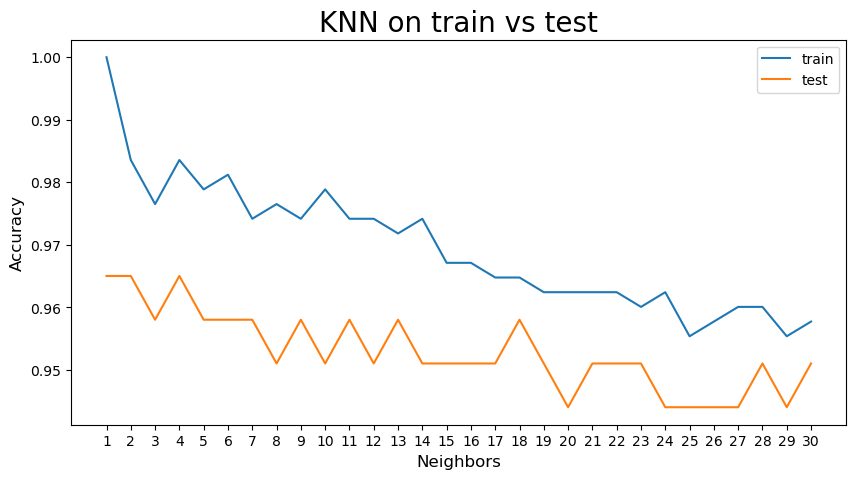

In [16]:
num_neighbors = np.arange(
    1, 31
)  # array of the numbers of nearest neigbors from 1 to 30
train_quality = np.zeros(num_neighbors.shape[0])  # quality on train data
test_quality = np.zeros(num_neighbors.shape[0])  # quality on test data

for i in range(num_neighbors.shape[0]):
    knn = KNeighborsClassifier(n_neighbors=num_neighbors[i])
    knn.fit(x_train_norm, y_train)

    # accuracy on train data
    train_quality[i] = accuracy_score(y_pred=knn.predict(x_train_norm), y_true=y_train)

    # accuracy on test data
    test_quality[i] = accuracy_score(y_pred=knn.predict(x_test_norm), y_true=y_test)

# accuracy plot  on train and test data
plt.figure(figsize=(10, 5))
plt.title("KNN on train vs test", size=20)
plt.plot(num_neighbors, train_quality, label="train")
plt.plot(num_neighbors, test_quality, label="test")
plt.legend()
plt.xticks(num_neighbors)
plt.xlabel("Neighbors", size=12)
plt.ylabel("Accuracy", size=12)
plt.show()

Вот, теперь мы видим, что 1 сосед был "ложной тревогой". Такие случаи мы называем *переобучением*. Чтобы действительно предсказывать что-то полезное, нам надо выбирать число соседей, начиная минимум с 3

## ЗАДАНИЯ

### Задание 1. Алгоритм Nearest Neighbors.



Хотя в лекции дан пример для изображений, реализация для табличных данных будет проще, либо вообще может не отличаться от предложенной.

P.S. Nearest Neighbor это  K-Nearest Neighbors при K = 1

Разбейте ваши данные на тренировочный и тестовый набор при помощи метода `train_test_split()`. Используйте следующие аргументы `train_size=0.6`, `random_state=42`, `stratify=labels`

In [60]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(data, labels, train_size=0.6, random_state=42, stratify=labels)
print("x_train", x_train.shape)
print("x_test", x_test.shape)

x_train (90, 4)
x_test (60, 4)


Напишите функцию, которая считает расстояние L1 между 2мя векторами


In [63]:
def compute_L1(a, b):
#   dist = np.abs(a-b)
  return np.sum(dist)
#checking
a = np.array([1,2,3,4])
b = np.array([2,1,3,4])
compute_L1(a, b)

2

Возьмите первую строку из тестового набора. Посчитайте расстояние L1 от нее до всех строк тренировочного набора.

В простейшем виде напишите `for loop`, если вы знаете что вы делаете - можете использовать *векторизацию*

In [71]:
# Your code here 
raw_0 = x_test[0]
# distances = np.array([compute_L1(raw_0, x_train[i]) for i in range(1,len(x_train))])
distances

array([ 0.6,  5.3,  5.2,  0.5,  0.9,  0.6,  1.4,  8.5,  8.1,  0.8,  8.3,
        4.5,  8.7,  5. ,  6.3,  0.8,  0.9,  6.9,  1.9,  0.2,  6.6,  7.5,
        6.1,  1. ,  6.8,  0.8,  6. ,  8.2,  0.3,  5.1,  0.9,  6.7,  0.9,
       11.2,  7. ,  7.1,  6. ,  1. ,  7. , 10. ,  6.7,  1.7, 10.2,  7.1,
        0.5,  4.4,  0.3,  4.7,  5.7,  6.9,  8.6,  4.5,  8.4,  5.3,  7.8,
        0.8,  9.3,  7.6,  6.2,  7.1,  7.1, 10.3,  1.2,  7.7,  1. ,  7.7,
        1.1,  1.6,  8.7, 10. ,  1.3,  6.9,  7.3,  7.4,  0.8,  5.4,  6.7,
        5.5,  4.9,  8.2,  0.5,  4.7,  7.2,  4.9,  0.5,  5.2,  1.4,  5.2,
        1.1])

Найдите индекс минимального расстояния

Используйте `np.argmin()`

In [72]:
indx = np.argmin(distances)
indx

19

Выведете на экран свойства первого ириса в тестовом наборе и ириса, который максимально на него похож в тренировочном(минимальное расстояние)

In [73]:
print('first iris in test', raw_0)
train_raw_most_similar = x_train[indx]
print('most similar iris in train', train_raw_most_similar)

first iris in test [5.  3.5 1.3 0.3]
most similar iris in train [5.7 4.4 1.5 0.4]


Выведите их метки

In [74]:
print('first iris in test labels', y_test[0])
print('most similar iris in train labels', y_train[indx])

first iris in test labels 0
most similar iris in train labels 0


Посчитайте двумерный массив расстояний от каждого ириса в тестовом наборе до каждого ириса в тренировочном. Размерность массива должна получиться (60, 90)

In [79]:
def compute_distances(train, test, distance_func):
#     distances = []
#     for test_iris in test:
#       dist = []
#       for train_iris in train:
#         dist.append(distance_func(test_iris,train_iris))
#       distances.append(np.array(dist))
#     distances = np.array(distances)
    return distances

In [80]:
distances = compute_distances(x_train, x_test, compute_L1)

In [81]:
distances.shape

(60, 90)

Определите точность Nearest Neighbors классификации

Для этого найдите индекс минимального значения для каждой строки массива distances

In [84]:
indx_distances =np.array([np.argmin(dist) for dist in distances])
indx_distances, len(indx_distances)

(array([20,  3, 71, 29, 76, 16, 79, 46, 28, 80, 59, 37, 61, 77, 33, 56, 56,
        33, 55, 43, 32, 46,  0, 80, 15, 80, 22, 81, 18,  4, 11, 27, 72,  6,
         1, 64, 38,  3, 45, 73, 32,  9, 84, 37, 30, 50, 86, 75, 65, 59, 87,
        15, 41, 46, 13, 51,  4, 84,  7, 81]), 60)

Теперь создадим массив `predicted_class`

In [85]:
predicted_class = y_train[indx_distances]

И посмотрим где класс предсказан правильно, а где нет

In [86]:
y_test == predicted_class

array([ True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

**Посчитайте точность (accuracy)**

В питоне с булевыми значениями можно производить математические операции (True = 1, False = 0)

In [87]:
accuracy = (len(y_test) - np.sum(np.abs(predicted_class-y_test)))/len(y_test)
print(f'Accuracy = {accuracy * 100:.1f}%')

Accuracy = 93.3%


Повторите все этапы классификации, однако в этот раз стандартизируйте данные перед этим.

In [93]:
def standartize(data):
#   mean = np.mean(data)
#   std = np.std(data)
#   st_data = (data - mean)/std
  return st_data
x_train_st, x_test_st = standartize(x_train),standartize(x_test)

In [96]:
distances_st = compute_distances(x_train_st, x_test_st, compute_L1)

In [98]:
indx_distances_st =np.array([np.argmin(dist) for dist in distances_st])
min_distances = y_train[indx_distances_st]
predicted_class = min_distances#y_train_st[indx_distances_st]
accuracy =  (len(y_test) - np.sum(np.abs(predicted_class-y_test)))/len(y_test)
print(f'Accuracy = {accuracy * 100:.1f}%')

Accuracy = 96.7%


### Формат результата

Получить точность (accuracy) больше 94%

### Задание 2. Nearest Neighbors для картинок

Загрузим датасет с помощью функций torchvision, пока можно не очень вдумываться как это работает, дальше в курсе мы познакомимся с PyTorch значительно ближе

In [99]:
from torchvision import datasets
import numpy as np

dataset = datasets.CIFAR10("content", train=True, download=True)

np.random.seed(42)
data, _, labels, _ = train_test_split(dataset.data / 255,  # Normalize
                                      np.array(dataset.targets),
                                      train_size=0.1, # get only fraction of the dataset
                                      random_state=42,
                                      stratify=dataset.targets)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting content/cifar-10-python.tar.gz to content


Посмотрим что это за датасет такой

In [100]:
data.shape

(5000, 32, 32, 3)

CIFAR - 4х мерный массив (N, W, H, C). $N$ - количество картинок, $W$ - ширина картинки, $H$ - высота картинки, $C$ - количество каналов (RGB).

Создайте subplots с 2мя строками и 2мя колонками и отобразите 4 любых картинки из `data`. 
Используйте `plt.imshow()`

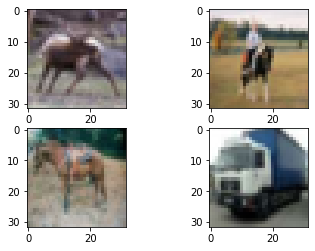

In [104]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=2)

ax[0, 0].imshow(data[0])# Your code here 
ax[0, 1].imshow(data[1])# Your code here 
ax[1, 0].imshow(data[2])# Your code here 
ax[1, 1].imshow(data[-1])# Your code here 
plt.show()

Разбейте датасет на тренировочный и тестовый наборы. Укажите аргументы `random_state=42`, `stratify=labels`

In [105]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(data, labels,random_state=42, stratify=labels)# Your code here 

print("x_train", x_train.shape)
print("x_test", x_test.shape)

x_train (3750, 32, 32, 3)
x_test (1250, 32, 32, 3)


Возьмите первую картинку из тестового набора и найдите ее ближайшего соседа из тренировочного

In [106]:
def compute_L1(a, b):
#   dist = np.abs(a-b)
  return np.sum(dist)

In [107]:
im_test_0 = x_test[0]
distances = np.array([compute_L1(im_test_0, x_train[i]) for i in range(1,len(x_train))])

In [108]:
indx = np.argmin(distances)
print(indx)

1452


**Отобразите эти картинки на subplots с ncols=2**

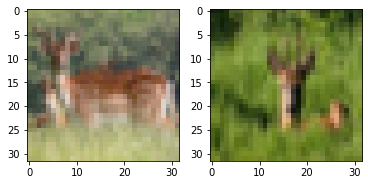

In [109]:
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(im_test_0)# Your code here 
ax[1].imshow(x_train[indx])# Your code here 
plt.show()

**Посмотрите какой класс предсказывается**

In [110]:
class_pred = y_train[indx]
class_to_idx = dataset.class_to_idx

print(list(class_to_idx.keys())[list(class_to_idx.values()).index(class_pred)])

deer


Возьмите первую картинку из тестового набора и найдите K ее ближайших соседей (KNN) из тренировочного

In [115]:
k = 5
indx = np.argsort(distances)[:k]# Your code here 
indx#,distances[indx], min(distances)

array([1452, 3348,  447, 2993, 1335])

Отобразите ближайших соседей в виде subplots

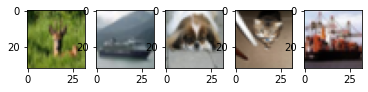

In [112]:
fig, ax = plt.subplots(nrows=1, ncols=k)# Your code here 
for i in range(k):
  ax[i].imshow(x_train[indx[i]])
plt.show()

Посчитайте KNN для всего датасета

Чем больше данных - тем дольше процесс. Реализуйте функцию для расчета расстояний. Если вы используете `for loops` - сделайте к ним *progress bars* с помощью [tqdm](https://github.com/tqdm/tqdm)

Примечание: если используете вложенные циклы используйте `tqdm` только на внешнем цикле. Иначе время работы существенно увеличится.

In [116]:
from tqdm.notebook import tqdm

In [121]:
def compute_distances(train, test, distance_func):
#   distances = []
#   for test_im in tqdm(test):
#     dist = []
#     for train_im in train:
#       dist.append(distance_func(test_im,train_im))
#     distances.append(np.array(dist))
#   distances = np.array(distances)
  return distances

In [122]:
distances = compute_distances(x_train, x_test, compute_L1)

  0%|          | 0/1250 [00:00<?, ?it/s]

In [132]:
distances.shape, len(distances)

((1250, 3750), 1250)

Теперь найдите k ближайших соседей и предскажите класс. [scipy.stats.mode](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mode.html)

In [151]:
from scipy.stats import mode
indxs = np.array([np.argsort(distance)[:k] for distance in distances])
pred = mode(y_train[indxs], axis=1)[0].flatten()
print('predicted class is',pred)
def get_accuracy(distances, train_labels, test_labels, k):
#   indxs = np.array([np.argsort(distance)[:k] for distance in distances])
#   pred = mode(y_train[indxs], axis=1)[0].flatten()
#   accuracy = np.mean(np.array(test_labels==pred))
  return accuracy

predicted class is [4 8 8 ... 6 4 0]


In [152]:
accuracy = get_accuracy(distances, y_train, y_test, k)
print(f'Accuracy = {accuracy * 100:.0f}%')

Accuracy = 31%


**Посчитайте точность для k=1..100 и постройте график точности от k**

In [153]:
acc = []
for k in range(1, 100):
    acc.append(get_accuracy(distances, y_train, y_test, k))

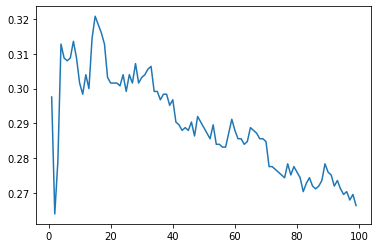

In [155]:
kk = np.arange(1,100)
plt.plot(kk,acc)# Your code here 
plt.show()

Поменяйте расстоянние L1 на L2 и сравните точность на всем датасете.

In [168]:
def distance_func_l2(a,b):
#   dist = np.sqrt(np.sum((a-b)**2))
  return dist
def compute_L2(train, test,distance_func_l2):
#   distances = []
#   for test_im in tqdm(test):
#     dist = []
#     for train_im in train:
#       dist.append(distance_func_l2(test_im,train_im))
#     distances.append(np.array(dist))
#   distances = np.array(distances)
  return distances
#check
distance_func_l2(a,b)

1.4142135623730951

In [170]:
acc_l2 = []
for k in range(1, 100):
    acc_l2.append(get_accuracy(distances_l2, y_train, y_test, k))

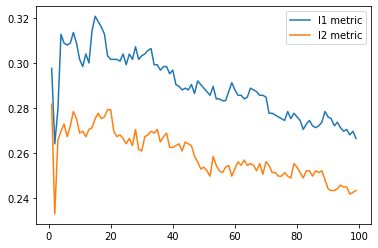

best k for l1 metric = 15
best k for l2 metric = 1


In [196]:
plt.plot(kk,acc, label = 'l1 metric')# Your code here 
plt.plot(kk,acc_l2, label = 'l2 metric')# Your code here 
plt.legend()
plt.show()
max_k_l1 = np.argmax(acc)+1
max_k_l2 = np.argmax(acc_l2)+1
print('best k for l1 metric =',max_k_l1)
print('best k for l2 metric =',max_k_l2)

### Формат результата

* График сравнения точности для L1 и L2 при различных k.
* Число k при котором достигается лучшая точность

Пример графика:

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/Exercises/EX01/result_4_task.png" width="300">

### Задание 3 (EXTRA). Реализация kNN

Часто KNN реализуют в концепции Объектно-Ориентированного Программирования (ООП). Создайте класс kNN и реализуйте у него методы

In [189]:
class kNN:
    def __init__(self, k, distance_func):
        self.k = k# Your code here 
        self.distance_func = distance_func# Your code here 

    def fit(self, x, y):
        self.train_data = x# Your code here 
        self.train_labels = y# Your code here 

    def predict(self, x):
        distances = self.compute_distances(x)
        indexes = np.argsort(distances, axis=1)[:, :self.k]
        labels_of_top_classes = self.train_labels[indexes]
        predicted_class, _ = mode(labels_of_top_classes, axis=1)
        return predicted_class.flatten()

    def compute_distances(self, test):
        # Your code here 
#       distances = []
#       for test_im in tqdm(test):
#         dist = []
#         for train_im in self.train_data:
#           dist.append(self.distance_func(test_im,train_im))
#         distances.append(np.array(dist))
#       distances = np.array(distances)
#       return distances

In [194]:
%%time
kNN_classifier = kNN(k=1, distance_func=compute_L1)
kNN_classifier.fit(x=x_train, y=y_train)
out = kNN_classifier.predict(x_test)

  0%|          | 0/1250 [00:00<?, ?it/s]

CPU times: user 50.2 s, sys: 386 ms, total: 50.6 s
Wall time: 51.2 s


In [198]:
acur = np.mean(y_test == out)
print(f'Accuracy = {acur * 100:.0f}%')

Accuracy = 30%


Сравните время работы вашей реализации и реализации из sklearn

In [175]:
from sklearn.neighbors import KNeighborsClassifier

In [199]:
%%time
neigh = KNeighborsClassifier(n_neighbors=1, metric = 'l1') #deafault metric is l2 = euclidean
x_train_fl = [x_train[i].flatten() for i in range(len(x_train))]
x_test_fl = [x_test[i].flatten() for i in range(len(x_test))]
neigh.fit(x_train_fl, y_train)
preds = neigh.predict(x_test_fl)
accur = np.mean(y_test == preds)
print(f'Accuracy = {accur * 100:.0f}%')

Accuracy = 30%
CPU times: user 7.72 s, sys: 131 ms, total: 7.85 s
Wall time: 7.82 s


### Формат результата

Демонстрация времени работы вашей реализации и реализации из sklearn (с помощью %%time)